# Homework 4 - Getting to know your customers

## 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study.

## 1.1 Set up the data

For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.


First of all we use pandas to import the dataset of transaction of a bank in India. The features that could be useful to match similar consumer given the bank accont information are: CustomerID, CustomerDOB (to group by similar ages), CustGender, CustAccountBalance (to group by richness) and TransactionAmount (to group by how much money they use). We are not interested in location (all are in India) and the time of the transaction, but we'll keep transaction date to calculate the age of the person at the year in which the data are taken.

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [141]:
df = pd.read_csv('/Users/giacomo/Desktop/ADM_HM4/bank_transactions.csv', usecols = ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'TransactionDate', 'CustAccountBalance', 'TransactionAmount (INR)'])

In [142]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,17819.05,2/8/16,25.0
1,T2,C2142763,4/4/57,M,2270.69,2/8/16,27999.0
2,T3,C4417068,26/11/96,F,17874.44,2/8/16,459.0
3,T4,C5342380,14/9/73,F,866503.21,2/8/16,2060.0
4,T5,C9031234,24/3/88,F,6714.43,2/8/16,1762.5
...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,7635.19,18/9/16,799.0
1048563,T1048564,C6459278,20/2/92,M,27311.42,18/9/16,460.0
1048564,T1048565,C6412354,18/5/89,M,221757.06,18/9/16,770.0
1048565,T1048566,C6420483,30/8/78,M,10117.87,18/9/16,1000.0


The dataset is composed by 1048567 transactions and 7 features referred to: TransactionID, CustomerID	CustomerDOB, CustGender, CustAccountBalance, TransactionDate, TransactionAmount (INR). Let's have a look into the missing values:

In [143]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustAccountBalance         2369
TransactionDate               0
TransactionAmount (INR)       0
dtype: int64

Given that the dataset is composed by 1048567 rows the missing values are a small percentage, so we decide to drop them: 

In [144]:
df = df.dropna()

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041765 entries, 0 to 1048566
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041765 non-null  object 
 1   CustomerID               1041765 non-null  object 
 2   CustomerDOB              1041765 non-null  object 
 3   CustGender               1041765 non-null  object 
 4   CustAccountBalance       1041765 non-null  float64
 5   TransactionDate          1041765 non-null  object 
 6   TransactionAmount (INR)  1041765 non-null  float64
dtypes: float64(2), object(5)
memory usage: 63.6+ MB


Now we decide to convert into datetime the date of birthday of the customers and the date of the transaction:

In [146]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

df['TransactionDate'] = pd.to_datetime(df['TransactionDate']) 

In [147]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,17819.05,2016-02-08,25.0
1,T2,C2142763,2057-04-04,M,2270.69,2016-02-08,27999.0
2,T3,C4417068,1996-11-26,F,17874.44,2016-02-08,459.0
3,T4,C5342380,1973-09-14,F,866503.21,2016-02-08,2060.0
4,T5,C9031234,1988-03-24,F,6714.43,2016-02-08,1762.5
...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,7635.19,2016-09-18,799.0
1048563,T1048564,C6459278,1992-02-20,M,27311.42,2016-09-18,460.0
1048564,T1048565,C6412354,1989-05-18,M,221757.06,2016-09-18,770.0
1048565,T1048566,C6420483,1978-08-30,M,10117.87,2016-09-18,1000.0


In [149]:
df['TransactionDate'].dt.year.value_counts()

2016    1041765
Name: TransactionDate, dtype: int64

All the data are taken in 2016, so we'll use this year to calculate the ages.

Going through the Date of Birthday we can see that there is something strange: there are dates of birthday referred to 1800, probably cause it is a default value when this data is missing, and a right tail that seems to be a part of the right graph with an offset: 

<BarContainer object of 100 artists>

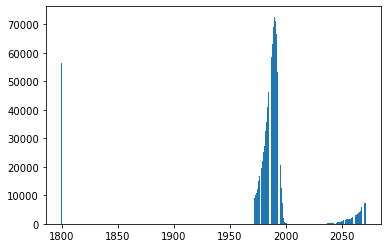

In [150]:
count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values(), label = 'year')

We decide to drop data related to years 1800 and rearrange the data after year 2000: 

<BarContainer object of 99 artists>

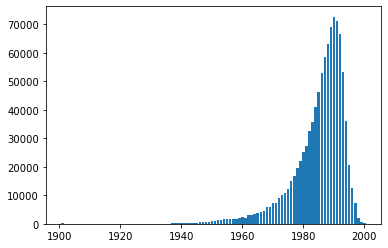

In [151]:
df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

df.drop(df[df.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values(), label = 'year')

Now we can create a 'CustomerAge' column: 

In [153]:
df['CustomerAge'] = (df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year)

<BarContainer object of 99 artists>

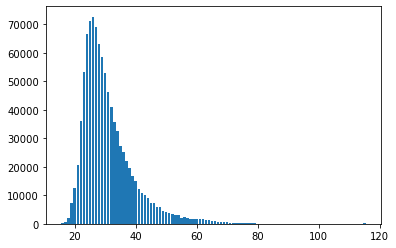

In [154]:
count = Counter(df['CustomerAge'])

plt.bar(count.keys(), count.values(), label = 'year')

Exploring the ages at the edges we can see that: 

In [155]:
df['CustomerAge'].min()

16

In [156]:
df['CustomerAge'].max()

115

Considering that the oldest person ever in India was Lucy d'Abreu who lived 113 years and 197 days (ref: Wikipedia) it seems a good choice to drop all the ages over 100 years.

In [158]:
df.drop(df[df.CustomerAge > 100].index, axis=0, inplace=True)

<BarContainer object of 84 artists>

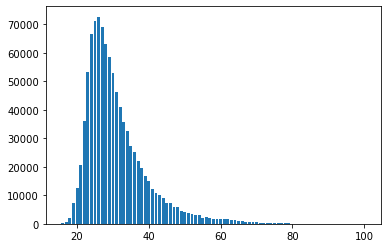

In [159]:
count = Counter(df['CustomerAge'])

plt.bar(count.keys(), count.values(), label = 'year')

Everythings looks fine now, so we can drop the columns referred to the TransactionDate and CustomerDOB.  

In [160]:
del df['CustomerDOB'], df['TransactionDate'] 

In [161]:
df

,TransactionID,CustomerID,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge
0,T1,C5841053,F,17819.05,25.0,22
1,T2,C2142763,M,2270.69,27999.0,59
2,T3,C4417068,F,17874.44,459.0,20
3,T4,C5342380,F,866503.21,2060.0,43
4,T5,C9031234,F,6714.43,1762.5,28
...,...,...,...,...,...,...
1048562,T1048563,C8020229,M,7635.19,799.0,26
1048563,T1048564,C6459278,M,27311.42,460.0,24
1048564,T1048565,C6412354,M,221757.06,770.0,27
1048565,T1048566,C6420483,M,10117.87,1000.0,38


We cast transaction amount and account balance to int: 

In [42]:
df['TransactionAmount (INR)'] = df['TransactionAmount (INR)'].astype(int)

df['CustAccountBalance'] = df['CustAccountBalance'].astype(int)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041765 entries, 0 to 1048566
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1041765 non-null  object        
 1   CustomerID               1041765 non-null  object        
 2   CustomerDOB              1041765 non-null  datetime64[ns]
 3   CustGender               1041765 non-null  object        
 4   CustAccountBalance       1041765 non-null  int64         
 5   TransactionAmount (INR)  1041765 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 55.6+ MB


## 1.2 Fingerprint hashing
Using the previously selected data with the features you found pertinent, you have to:

1. Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the book.

2. Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

## 1.3 Locality Sensitive Hashing
Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download this csv and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results.